# 1. Build your own convolutional neural network using pytorch

In [11]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths to datasets
train_dataset_path = '/content/drive/My Drive/Dog_Heart/Train'
val_dataset_path = '/content/drive/My Drive/Dog_Heart/Valid'
test_dataset_path = '/content/drive/My Drive/Dog_Heart/Test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [14]:
# Custom Dataset for Test Data
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# Load datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dataset_path, transform=val_transforms)
test_dataset = CustomTestDataset(root_dir=test_dataset_path, transform=test_transforms)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNNCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(-1, 1024 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 45
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Train model
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the model if the validation loss decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/UsualCnn_model.pth')
        print(f'Saving model with validation loss {val_loss:.4f}')

# Testing and Saving Results
model.load_state_dict(torch.load('/content/drive/My Drive/UsualCnn_model.pth'))
model.eval()

test_predictions = []
image_paths = []
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

# Save predictions to CSV
def save_predictions_to_csv(predictions, filenames, filename):
    filenames = [os.path.basename(path) for path in filenames]
    df = pd


Epoch [1/45], Train Loss: 1.0132, Val Loss: 1.0025
Saving model with validation loss 1.0025
Epoch [2/45], Train Loss: 1.0087, Val Loss: 0.9921
Saving model with validation loss 0.9921
Epoch [3/45], Train Loss: 0.9964, Val Loss: 0.9870
Saving model with validation loss 0.9870
Epoch [4/45], Train Loss: 0.9913, Val Loss: 0.9764
Saving model with validation loss 0.9764
Epoch [5/45], Train Loss: 0.9844, Val Loss: 0.9400
Saving model with validation loss 0.9400
Epoch [6/45], Train Loss: 0.9552, Val Loss: 0.9131
Saving model with validation loss 0.9131
Epoch [7/45], Train Loss: 0.9347, Val Loss: 0.8816
Saving model with validation loss 0.8816
Epoch [8/45], Train Loss: 0.9102, Val Loss: 0.8332
Saving model with validation loss 0.8332
Epoch [9/45], Train Loss: 0.9046, Val Loss: 0.7419
Saving model with validation loss 0.7419
Epoch [10/45], Train Loss: 0.8750, Val Loss: 0.7938
Epoch [11/45], Train Loss: 0.8763, Val Loss: 0.7490
Epoch [12/45], Train Loss: 0.8676, Val Loss: 0.7344
Saving model wit

<ipython-input-14-b668d4627b86>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/UsualCnn_model.pth'))


In [15]:
# Save predictions to CSV without headers
def save_predictions_to_csv(predictions, filenames, filename):
    filenames = [os.path.basename(path) for path in filenames]
    # Combine filenames and predictions into a list of tuples
    data = list(zip(filenames, predictions))
    # Write to CSV without headers
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False, header=False)

# Save the results to Google Drive
save_predictions_to_csv(test_predictions, image_paths, '/content/drive/My Drive/UsualCnn_test_predictions.csv')

# 3. Evaluate your model using the developed software

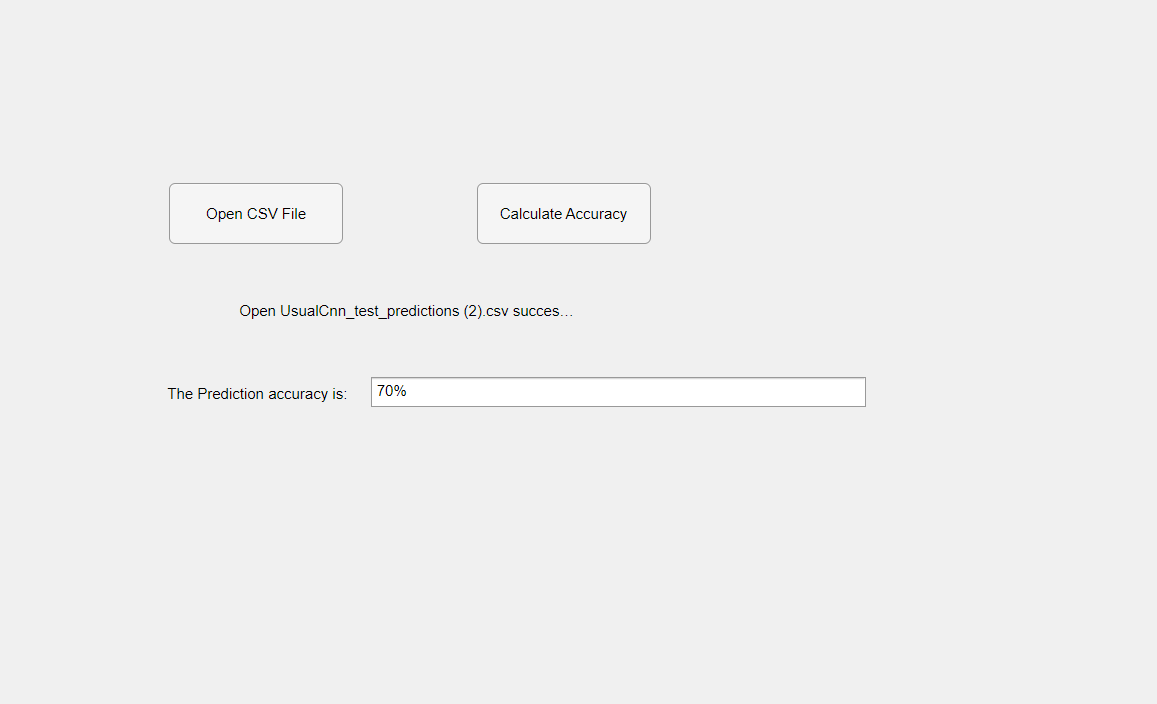

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

### Comparison of UsualCNN and RVT

#### **Performance Overview**
- **UsualCNN**: Achieves 70.5% accuracy, outperforming AlexNet (68.3%) and VGG16 (69.5%) but below the 75% benchmark.
- **RVT**: Surpasses 75% due to attention mechanisms, residual connections, and pretraining on large datasets.

---

### **Why RVT Performs Better**
1. **Attention Mechanisms**: Focuses on key image regions.
2. **Residual Connections**: Enables efficient training of deep networks.
3. **Pretraining**: Leverages large datasets for strong feature extraction.

---

### **How to Improve UsualCNN**
1. Add **attention mechanisms** (CBAM, SE-Blocks).
2. Use **transfer learning** with pre-trained models.
3. Expand the dataset or use advanced **data augmentation** (MixUp, CutMix).
4. Add **residual connections** for better gradient flow.
5. Optimize **hyperparameters** and regularization techniques.

---

### **Conclusion**
With these enhancements, UsualCNN can achieve or exceed 75%, making it competitive with RVT and suitable for more advanced tasks.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

ResearchGate link: https://www.researchgate.net/publication/385944507_Implementation_and_Analysis_of_a_Custom_CNN_Architecture_for_Dog_Heart_Image_Classification

Github link: https://github.com/priyadarshini-777/Implementation-and-Analysis-of-a-Custom-CNN-Architecture-for-Dog-Heart-Image-Classification

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 70 % -->10 points
     < 50 % -->0 points
     >= 50 % & < 70% --> 0.5 point/percent
     

(6). Discussion - 10 points